# Extended repressilator

This repressilator includes additional "steps" - signalling molecules that act as intermediates between repressors.

In [1]:
pip install -e .

Note: you may need to restart the kernel to use updated packages.


ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: c:\Users\User\OneDrive\Desktop\Masters PJ\GitHub\LOICA\notebooks\repressilators


In [2]:
import loica as lc
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# AiiA expressed continuosly

In [3]:
def growth_rate(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
genetic_n = lc.GeneticNetwork()

In [4]:
strain = lc.Strain('Strain', genetic_n, metab)

In [5]:
aiia = lc.Regulator(name='AiiA', degradation_rate=1.02)
genetic_n.add_regulator(aiia)

In [6]:
# Transcription factors
laci = lc.Regulator(name='LacI', degradation_rate=1.02, init_concentration=10**-7)
tetr = lc.Regulator(name='TetR', degradation_rate=1.02)
ci = lc.Regulator(name='cI', degradation_rate=1.02)

# Signalling molecules
c4 = lc.Regulator(name='C4', diffusion_rate=180)
scb2 = lc.Regulator(name='SCB2', diffusion_rate=180)
c14 = lc.Regulator(name='C14', diffusion_rate=126)

genetic_n.add_regulator([tetr, laci, ci, c4, scb2, c14])

In [7]:
# option with producers
rhli = lc.Regulator(name='RhlI', degradation_rate=1.02)
scbb = lc.Regulator(name='ScbB', degradation_rate=1.02)
cini = lc.Regulator(name='CinI', degradation_rate=1.02)
genetic_n.add_regulator([rhli, scbb, cini])

In [8]:
mcherry = lc.Reporter(name='mCherry', degradation_rate=1.02, color='red') 
cyan = lc.Reporter(name='CFP', degradation_rate=1.02, color='blue') 
mven = lc.Reporter(name='mVenus', degradation_rate=1.02, color='yellow') 

genetic_n.add_reporter([mcherry, cyan, mven])

In [9]:
j23100 = lc.Source(output=aiia, rate=2.56*10**-7, name='J23100')

#First extended node
c4_laci = lc.Hill1(name='Prhl', input=c4, output=[laci, cyan], alpha=[0, 2.15*10**-8], K=4.68*10**-5, n=0.64)
laci_not_scbb = lc.Hill1(name='Plac', input=laci, output=scbb, alpha=[1.44*10**-4, 1.44*10**-7], K=6.64*10**-8, n=2)
scbb_scb2 = lc.Producer(name='ScbB', enzyme=scbb, product=scb2, k2=66)

# Second
scb2_tetr = lc.Hill1(name='Pscb', input=scb2, output=[tetr, mcherry], alpha=[1.61*10**-8, 2.74*10**-7], K=5.49*10**-10, n=1.05)
tetr_not_cini = lc.Hill1(name='Ptet', input=tetr, output=cini, alpha=[1.44*10**-4, 1.44*10**-7], K=6.64*10**-8, n=2)
cini_c14 = lc.Producer(name='CinI', enzyme=cini, product=c14, k2=60)

# Third
c14_ci = lc.Hill1(name='Pcin', input=c14, output=[ci, mven], alpha=[2.15*10**-8, 7.35*10**-8], K=3.41*10**-6, n=1.87)
ci_not_rhli = lc.Hill1(name='PcI', input=ci, output=rhli, alpha=[1.44*10**-4, 1.44*10**-7], K=6.64*10**-8, n=2)
rhli_c4 = lc.Producer(name='RhlI', enzyme=rhli, product=c4, k2=960)

genetic_n.add_operator([c4_laci, laci_not_scbb, scb2_tetr, tetr_not_cini, c14_ci, ci_not_rhli, j23100])
genetic_n.add_impactor([scbb_scb2, cini_c14, rhli_c4])

In [10]:
lactonase = lc.Degrader(name='Lactonase', enzyme=aiia, substrate=[c4, c14, scb2], Km=[0.00511, 0.00143, 0.00383], k2=[1.35*10**5, 7.28*10**4, 1.28*10**5])
genetic_n.add_impactor(lactonase)


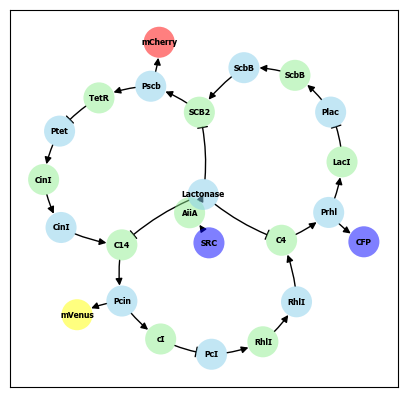

In [11]:
plt.figure(figsize=(5,5), dpi=100)
genetic_n.draw()

In [12]:
sample = lc.Sample(strain=strain)
assay = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='Extended repressilator',
                description='Simulated expression of extended repressilator strain'
                )

In [13]:
assay.run(substeps=100, mode="track_all")

100%|██████████| 100.0/100 [02:57<00:00,  1.78s/it]


Text(0, 0.5, 'Concentration (M)')

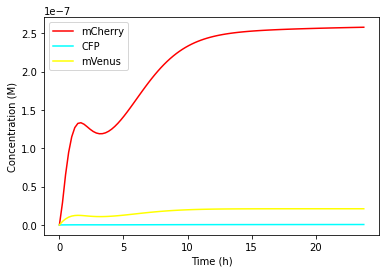

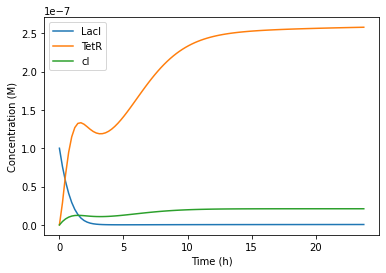

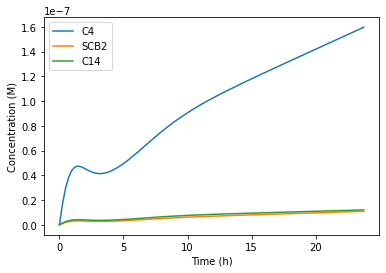

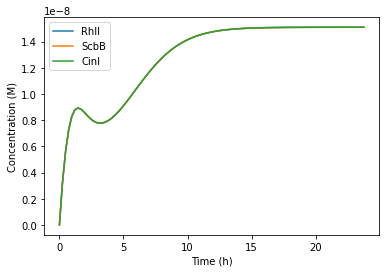

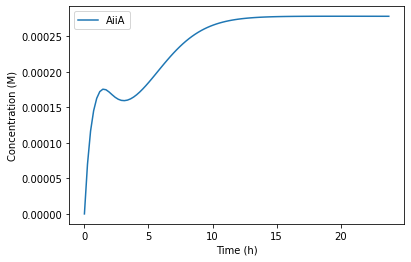

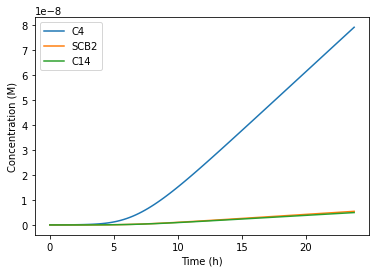

In [27]:
m = assay.measurements
fig, ax = plt.subplots()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
m[m.Signal=='mCherry in Strain'].plot(x='Time', y='Measurement', color='red', style='-', ax=ax)
m[m.Signal=='CFP in Strain'].plot(x='Time', y='Measurement', color='cyan', style='-', ax=ax)
m[m.Signal=='mVenus in Strain'].plot(x='Time', y='Measurement', color='yellow', style='-', ax=ax)
m[m.Signal=='LacI in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax1)
m[m.Signal=='TetR in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax1)
m[m.Signal=='cI in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax1)
m[m.Signal=='C4 in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax2)
m[m.Signal=='SCB2 in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax2)
m[m.Signal=='C14 in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax2)
m[m.Signal=='RhlI in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax3)
m[m.Signal=='ScbB in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax3)
m[m.Signal=='CinI in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax3)
m[m.Signal=='AiiA in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax4)
ax.legend(['mCherry', 'CFP', 'mVenus'])
ax.set_xlabel('Time (h)')
ax.set_ylabel('Concentration (M)')
ax1.legend(['LacI', 'TetR', 'cI'])
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Concentration (M)')
ax2.legend(['C4', 'SCB2', 'C14'])
ax2.set_xlabel('Time (h)')
ax2.set_ylabel('Concentration (M)')
ax3.legend(['RhlI', 'ScbB', 'CinI'])
ax3.set_xlabel('Time (h)')
ax3.set_ylabel('Concentration (M)')
ax4.legend(['AiiA'])
ax4.set_xlabel('Time (h)')
ax4.set_ylabel('Concentration (M)')

fig5, ax5 = plt.subplots()
m[m.Signal=='Extracellular C4'].plot(x='Time', y='Measurement', style='-', ax=ax5)
m[m.Signal=='Extracellular SCB2'].plot(x='Time', y='Measurement', style='-', ax=ax5)
m[m.Signal=='Extracellular C14'].plot(x='Time', y='Measurement', style='-', ax=ax5)
ax5.legend(['C4', 'SCB2', 'C14'])
ax5.set_xlabel('Time (h)')
ax5.set_ylabel('Concentration (M)')

## Continuous signals

In [15]:
def growth_rate(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
genetic_n = lc.GeneticNetwork()

In [16]:
strain = lc.Strain('Strain', genetic_n, metab)

In [17]:
aiia = lc.Regulator(name='AiiA', degradation_rate=1.02)
genetic_n.add_regulator(aiia)

In [18]:
# Transcription factors
laci = lc.Regulator(name='LacI', degradation_rate=1.02, init_concentration=10**-7)
tetr = lc.Regulator(name='TetR', degradation_rate=1.02)
ci = lc.Regulator(name='cI', degradation_rate=1.02)

# Signalling molecules
c4 = lc.Regulator(name='C4', diffusion_rate=180)
scb2 = lc.Regulator(name='SCB2', diffusion_rate=180)
c14 = lc.Regulator(name='C14', diffusion_rate=126)

genetic_n.add_regulator([tetr, laci, ci, c4, scb2, c14])

In [19]:
# option with producers
rhli = lc.Regulator(name='RhlI', degradation_rate=1.02)
scbb = lc.Regulator(name='ScbB', degradation_rate=1.02)
cini = lc.Regulator(name='CinI', degradation_rate=1.02)
genetic_n.add_regulator([rhli, scbb, cini])

In [20]:
mcherry = lc.Reporter(name='mCherry', degradation_rate=1.02, color='red') 
cyan = lc.Reporter(name='CFP', degradation_rate=1.02, color='blue') 
mven = lc.Reporter(name='mVenus', degradation_rate=1.02, color='yellow') 

genetic_n.add_reporter([mcherry, cyan, mven])

In [21]:
j23117 = lc.Source(output=[rhli, cini, scbb], rate=1.54*10**-8, name='J23117')

#First extended node
c4_laci = lc.Hill1(name='Prhl', input=c4, output=[laci, cyan], alpha=[0, 2.15*10**-8], K=4.68*10**-5, n=0.64)
laci_not_aiia = lc.Hill1(name='Plac', input=laci, output=aiia, alpha=[1.44*10**-4, 1.44*10**-7], K=6.64*10**-8, n=2)
scbb_scb2 = lc.Producer(name='ScbB', enzyme=scbb, product=scb2, k2=66)

# Second
scb2_tetr = lc.Hill1(name='Pscb', input=scb2, output=[tetr, mcherry], alpha=[1.61*10**-8, 2.74*10**-7], K=5.49*10**-10, n=1.05)
tetr_not_aiia = lc.Hill1(name='Ptet', input=tetr, output=aiia, alpha=[1.44*10**-4, 1.44*10**-7], K=6.64*10**-8, n=2)
cini_c14 = lc.Producer(name='CinI', enzyme=cini, product=c14, k2=60)

# Third
c14_ci = lc.Hill1(name='Pcin', input=c14, output=[ci, mven], alpha=[2.15*10**-8, 7.35*10**-8], K=3.41*10**-6, n=1.87)
ci_not_aiia = lc.Hill1(name='PcI', input=ci, output=aiia, alpha=[1.44*10**-4, 1.44*10**-7], K=6.64*10**-8, n=2)
rhli_c4 = lc.Producer(name='RhlI', enzyme=rhli, product=c4, k2=960)

genetic_n.add_operator([c4_laci, laci_not_aiia, scb2_tetr, tetr_not_aiia, c14_ci, ci_not_aiia, j23117])
genetic_n.add_impactor([scbb_scb2, cini_c14, rhli_c4])

In [22]:
lactonase = lc.Degrader(name='Lactonase', enzyme=aiia, substrate=[c4, c14, scb2], Km=[0.00511, 0.00143, 0.00383], k2=[1.35*10**5, 7.28*10**4, 1.28*10**5])
genetic_n.add_impactor(lactonase)


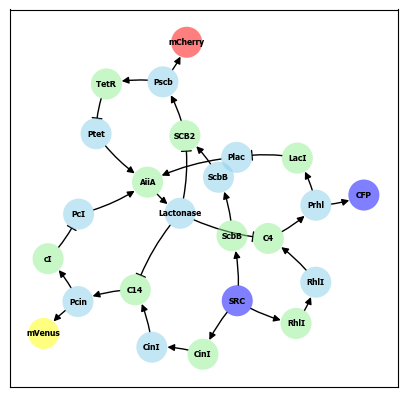

In [23]:
plt.figure(figsize=(5,5), dpi=100)
genetic_n.draw()

In [24]:
sample = lc.Sample(strain=strain)
assay = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='Extended repressilator',
                description='Simulated expression of extended repressilator strain'
                )

In [25]:
assay.run(substeps=100, mode="track_all")

100%|██████████| 100.0/100 [02:44<00:00,  1.65s/it]


Text(0, 0.5, 'Concentration (M)')

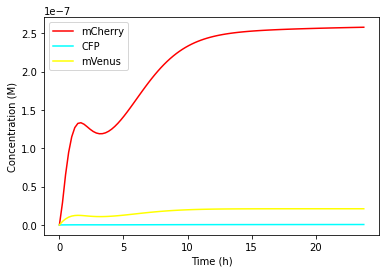

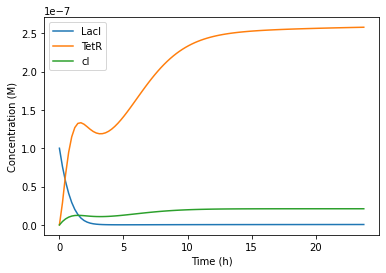

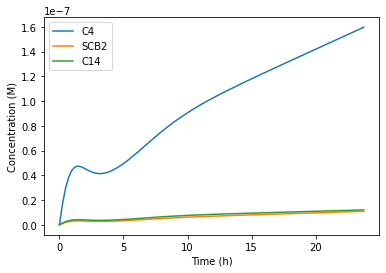

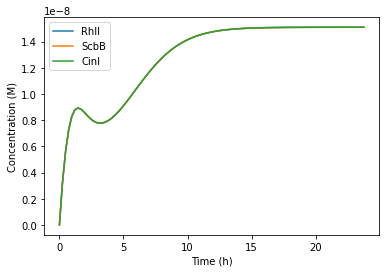

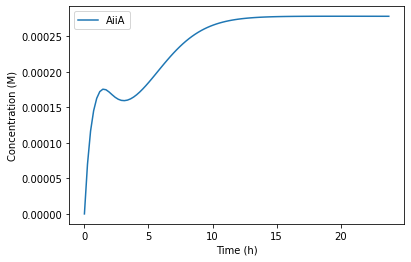

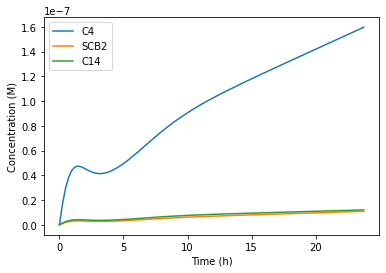

In [26]:
m = assay.measurements
fig, ax = plt.subplots()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
m[m.Signal=='mCherry in Strain'].plot(x='Time', y='Measurement', color='red', style='-', ax=ax)
m[m.Signal=='CFP in Strain'].plot(x='Time', y='Measurement', color='cyan', style='-', ax=ax)
m[m.Signal=='mVenus in Strain'].plot(x='Time', y='Measurement', color='yellow', style='-', ax=ax)
m[m.Signal=='LacI in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax1)
m[m.Signal=='TetR in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax1)
m[m.Signal=='cI in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax1)
m[m.Signal=='C4 in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax2)
m[m.Signal=='SCB2 in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax2)
m[m.Signal=='C14 in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax2)
m[m.Signal=='RhlI in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax3)
m[m.Signal=='ScbB in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax3)
m[m.Signal=='CinI in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax3)
m[m.Signal=='AiiA in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax4)
ax.legend(['mCherry', 'CFP', 'mVenus'])
ax.set_xlabel('Time (h)')
ax.set_ylabel('Concentration (M)')
ax1.legend(['LacI', 'TetR', 'cI'])
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Concentration (M)')
ax2.legend(['C4', 'SCB2', 'C14'])
ax2.set_xlabel('Time (h)')
ax2.set_ylabel('Concentration (M)')
ax3.legend(['RhlI', 'ScbB', 'CinI'])
ax3.set_xlabel('Time (h)')
ax3.set_ylabel('Concentration (M)')
ax4.legend(['AiiA'])
ax4.set_xlabel('Time (h)')
ax4.set_ylabel('Concentration (M)')

fig5, ax5 = plt.subplots()
m[m.Signal=='C4 in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax5)
m[m.Signal=='SCB2 in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax5)
m[m.Signal=='C14 in Strain'].plot(x='Time', y='Measurement', style='-', ax=ax5)
ax5.legend(['C4', 'SCB2', 'C14'])
ax5.set_xlabel('Time (h)')
ax5.set_ylabel('Concentration (M)')